In [8]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

import scipy.stats as stats

from scipy import stats

In [2]:
def t_test_values(input_BA): # give the input_BA as a string e.g. 'AEC'
    
    # get list of files from given BA
    list_of_hot_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', f'{input_BA}_*.csv'))
    list_of_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', f'{input_BA}_*.csv'))
    
    p_value_list = []
    # run for loop over list of the file names to return the t-test values
    for file_index in range(len(list_of_hot_files)):
        
        # read in csv files for hot and cold
        hot_df = pd.read_csv(list_of_hot_files[file_index], index_col = None, header = 0)
        hot_t2_array = hot_df['T2'].to_numpy()
        
        cold_df = pd.read_csv(list_of_cold_files[file_index], index_col = None, header = 0)
        cold_t2_array = cold_df['T2'].to_numpy()
        
        # get var for both hot and cold, to check if they have "equal" variance
        hot_var = np.var(hot_t2_array)
        cold_var = np.var(cold_t2_array)
        
        # check ratio of variances, then run the t-test if satisfied
        if hot_var > cold_var:
            if (hot_var / cold_var) > 4:
                print("The variances are unequal(ratio > 4)")
            else:
                t_stat, p_value = stats.ttest_ind(a = hot_t2_array, b = cold_t2_array, equal_var = True)
                
        else:
            if (cold_var / hot_var) > 4:
                print("The variances are unequal(ratio > 4)")
            else:
                t_stat, p_value = stats.ttest_ind(a = hot_t2_array, b = cold_t2_array, equal_var = True)
                
        # add p value to list for every year
        p_value_list.append(p_value)
    
    # return a list of the p values of each t-test
    return p_value_list

In [3]:
# run through t_test_values for every BA. return a list of the BAs where there exists a p-value greater than the input
def p_value_BA(input_p_value): # input the input_p_value as a float e.g. 0.05
    
    # get a list of the BAs
    list_of_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', "*.csv"))
    
    # get a list of unique BA names
    BA_names = []
    for file_index in range(len(list_of_files)):
        base_name = os.path.splitext(os.path.basename(list_of_files[file_index]))[0]
        split = base_name.split("_")
        if split[0] in BA_names:
            pass
        else:
            BA_names.append(split[0])
    
    insignificant_BA_list = []
    p_values = []
    # run t_test_values for each BA
    for BA in BA_names:
        p_value_list = t_test_values(BA)
        
        # check p values
        for p_value in p_value_list:
            if p_value > input_p_value:
                insignificant_BA_list.append(BA)
                p_values.append(p_value)
                break
            
    # return a list of BAs where there exists a year which would accept the null hypothesis that the difference in group means is zero
    return insignificant_BA_list, p_values

In [4]:
list_BA, list_p_value = p_value_BA(0.04)

In [5]:
# return a dataframe where each BA has an associated year where the null hypothesis switches from being accepted to rejected
def year_of_rejection(list_of_BA): # input the list_of_BA as a list of strings, each string a BA e.g. ['AEC','CPLE','DUK']
    
    # create list of possible years to reference
    years_list = list(range(20, 99))
    
    significant_indexes = []
    # run through BA names to get index of when p-value switches to significant
    for BA_name in list_of_BA:
        p_value_list = t_test_values(BA_name)
        
        # check when the p-value gets below certain
        for p_value in range(len(p_value_list)):
            if p_value_list[p_value] < 0.04:
                significant_indexes.append(p_value)
                break
    
    # align the years_list with the significant idexes
    significant_years = []
    for index in significant_indexes:
        significant_years.append(years_list[index])
        
    return significant_years

In [6]:
years_rejection = year_of_rejection(list_BA)

In [7]:
years_df = pd.DataFrame(years_rejection, columns = ["Year"])
years_df['BA'] = list_BA
years_df['P_Value'] = list_p_value
years_df = years_df[['BA', 'Year', 'P_Value']]
years_df

,BA,Year,P_Value
0,AEC,21,0.049156
1,CPLE,21,0.054969
2,DUK,21,0.073358
3,ERCO,21,0.148800
4,FPC,21,0.041901
5,GVL,21,0.041665
6,JEA,21,0.048265
7,LGEE,21,0.090001
8,NSB,21,0.063863
9,OVEC,21,0.267471


Okay it seems like what I'm testing is not that useful, as we should expect this result that the means are different. It is probably better to do stuff surrounding how different they are. With such a large sample, we can be pretty confident that the sample mean more closely resembles the population mean, and the two-sample t-test which tests for difference in means is obviously satisfied. 

Statistics=0.994, p=0.000
WAUW_WRF_Hourly_Mean_Meteorology_2099.csv Sample does not look Gaussian (reject H0)
Statistics=136.088, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 15.240
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


C:\projects\tell_3p10\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


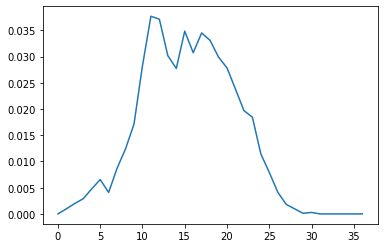

In [29]:
# run the three normality tests for a single year, they all return not normal
df = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD\AVA_WRF_Hourly_Mean_Meteorology_2020.csv', index_col = None, header = 0)
t2_bins = np.arange(250,325,2)
hist, bin_edges = np.histogram(df['T2'], bins = t2_bins, density = True)
plt.plot(hist)
stat, p = stats.shapiro(df['T2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print(name + ' Sample looks Gaussian (fail to reject H0)')
else:
    print(name + ' Sample does not look Gaussian (reject H0)')
    
stat2, p2 = stats.normaltest(df['T2'])
print('Statistics=%.3f, p=%.3f' % (stat2, p2))
if p2 > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
result = stats.anderson(df['T2'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [33]:
def data_chunk(first_year, files_path, input_BA): # input first_year as an integer: the first year of the decade you want e.g. 2020. input file_path as a raw string directory
                                                       # e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT' . input input_BA as a string e.g. 'AEC'
    # get a list of the files from the path
    list_of_files = glob.glob(os.path.join(files_path, f'{input_BA}_*.csv'))
    
    # get a list of the elements of each file name
    BA_list_split = []
    for file_index in range(len(list_of_files)):
        base_name = os.path.splitext(os.path.basename(list_of_files[file_index]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)

    # get a list of the BA names, with the same indexes as their original file names
    BA_names = []
    for file_list in BA_list_split:
        BA_names.append(file_list[0])
        
    # get the first file with which to start pulling hourly data
    for file_index in range(len(list_of_files)):
        if input_BA == BA_names[file_index]:
            if str(first_year) in list_of_files[file_index]:
                first_file = list_of_files[file_index]
                break
                
    # get a list of the 10 files to unpack
    index_first_file = list_of_files.index(first_file)
    decade_file_list = []
    for file in list_of_files[index_first_file:]:
        if len(decade_file_list) == 10:
            break
        decade_file_list.append(file)
        
    # create aggregate df of all t2 values from each file_name df
    t2_bins = np.arange(250,325,2)
    for file_name in range(len(decade_file_list)):
        
        # read in the file as a df
        df = pd.read_csv(decade_file_list[file_name], index_col = None, header = 0)
        
        # aggregate output into a new dataframe:
        if file_name == 0:
            aggregate_output_df = df
        else:
            aggregate_output_df = pd.concat([aggregate_output_df, df], axis = 0)
            
    return aggregate_output_df

In [39]:
hot_10 = pd.concat([data_chunk(2020, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'), 
                   data_chunk(2030, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2040, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2050, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2060, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2070, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2080, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2090, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC')], axis = 0)
print(hot_10)
alpha = 0.05
stat, p = shapiro(hot_10['T2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print(' Sample looks Gaussian (fail to reject H0)')
else:
    print(' Sample does not look Gaussian (reject H0)')
    
stat2, p2 = stats.normaltest(hot_10['T2'])
print('Statistics=%.3f, p=%.3f' % (stat2, p2))
if p2 > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

                 Time_UTC      T2       Q2  SWDOWN     GLW  WSPD
0     2020-01-01 01:00:00  281.85  0.00492    0.00  325.25  2.70
1     2020-01-01 02:00:00  281.55  0.00488    0.00  324.08  2.93
2     2020-01-01 03:00:00  281.17  0.00483    0.00  318.19  3.13
3     2020-01-01 04:00:00  280.79  0.00479    0.00  315.79  3.22
4     2020-01-01 05:00:00  280.37  0.00477    0.00  308.05  3.23
...                   ...     ...      ...     ...     ...   ...
8755  2099-12-31 19:00:00  290.28  0.00516  582.00  292.03  4.87
8756  2099-12-31 20:00:00  290.40  0.00522  464.51  293.97  4.75
8757  2099-12-31 21:00:00  290.00  0.00530  298.52  294.46  4.49
8758  2099-12-31 22:00:00  288.87  0.00548  134.60  293.39  3.71
8759  2099-12-31 23:00:00  286.54  0.00550    0.00  289.23  2.71

[701277 rows x 6 columns]
Statistics=0.987, p=0.000
 Sample does not look Gaussian (reject H0)
Statistics=21120.176, p=0.000
Sample does not look Gaussian (reject H0)


C:\projects\tell_3p10\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [32]:
# list_of_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', "*.csv"))

#for file in list_of_cold_files:
    # df = pd.read_csv(file, index_col = None, header = 0)
    # name = os.path.basename(file)
    # stat, p = shapiro(df['T2'])
    # alpha = 0.05
    # print('Statistics=%.3f, p=%.3f' % (stat, p))
    # if p > alpha:
        # print(name + ' Sample looks Gaussian (fail to reject H0)')
    # else:
        # print(name + ' Sample does not look Gaussian (reject H0)')